# Lab1: Ridge and Lasso Regression

### Purpose

In this lab, you will learn how to:

a. do rigdge regression and lasso regression. 

b. manipulate real dataset.

C. find the optimal tuning parameter through cross validation. 

### Useful libraries for this Lab

a. pandas, for data frame.

b. numpy, for data array.

c. matplotlib and seaborn, for plotting.

d. sklearn, for linear model regarding ridge and lasso.

e. os, for the working directory.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

We will use the sklearn package in order to perform ridge regression and the lasso. The main functions in this package that we care about are Ridge ( ), which can be used to fit ridge regression models, and Lasso ( ) which will fit lasso models. They also have cross-validated counterparts: RidgeCV ( ) and LassoCV ( ). We'll use these a bit later.
Before proceeding, let's first ensure that the missing values have been removed from the data, as described in the previous lab.

In [2]:
df = pd.read_csv('Hitters.txt').dropna().drop('Player', axis = 1)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [61]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


In [62]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7 KB


# Rigdge Regression

Ridge regression is similar to least squares except that the coefficients are estimated by minimizing a slightly different quantity. Ridge regression, like OLS, seeks coefficient estimates that reduce RSS, however they also have a shrinkage penalty when the coefficients come closer to zero. This penalty has the effect of shrinking the coefficient estimates towards zero. 

$$\hat{\beta}^{ridge} = argmin_{\beta}\{ \sum_{i=1}^N(y_i-\beta_0-\sum^p_{j=1}x_{ij}\beta_j)^2+\lambda\sum_{j=1}^p\beta_j^2\}$$

The parameter, $\lambda$, is a complexity parameter that controls the amount of the shrinking. The larger the value of $\lambda$, the greater the amount of shrinkage.$\lambda=0$ will behave exactly like OLS regression. Of course, selection a good value for $\lambda$ is critical, and should be chosen using Cross Validation techniques. 

The Ridge ( ) function has an argument $\lambda$， which is used to tune the model. We'll generate an array of $\lambda\ values ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit:

In [63]:
lambdas = 10**np.linspace(10,-2,100)*0.5
lambdas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)
<br>
Return evenly spaced numbers over a specified interval.

Associated with each $\lambda$ value is a vector of ridge regression coefficients, which we'll store in a matrix coefs. In this case, it is a  19×100 matrix, with 19 rows (one for each predictor) and 100 columns (one for each value of $\lambda$). Remember that we'll want to standardize the variables so that they are on the same scale. To do this, we can use the normalize = True parameter:

In [64]:
ridge = Ridge(normalize = True)
coefs = []

for a in lambdas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 19)

We expect the coefficient estimates to be much smaller, in terms of  L2 norm, when a large value of alpha is used, as compared to when a small value of $\lambda$ is used. Let's plot and find out:

Text(0,0.5,'weights')

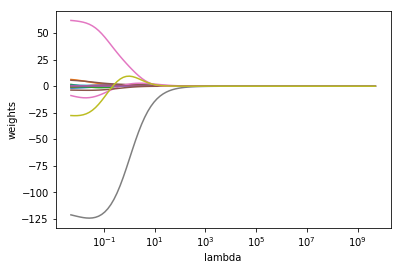

In [65]:
ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order to estimate the test error of ridge regression and the lasso:

In [66]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=4609)

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using  λ=2:

In [67]:
ridge2 = Ridge(alpha = 2, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

AtBat           0.141753
Hits            0.668616
HmRun           1.522311
Runs            1.170179
RBI             1.139994
Walks           0.636668
Years           2.804266
CAtBat          0.009991
CHits           0.039553
CHmRun          0.236122
CRuns           0.078977
CRBI            0.077546
CWalks          0.037872
PutOuts         0.054602
Assists         0.022183
Errors         -0.183342
League_N       25.098533
Division_W    -69.181000
NewLeague_N    28.514225
dtype: float64
98728.19898735828


The test MSE when $\lambda$ = 2 is 98728. Now let's see what happens if we use a huge value of alpha, say  $10^{10}$:

In [74]:
ridge3 = Ridge(alpha = 10**10, normalize = True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))          # Calculate the test MSE

AtBat          1.334472e-10
Hits           4.749451e-10
HmRun          1.943948e-09
Runs           8.217419e-10
RBI            8.945896e-10
Walks          8.441756e-10
Years          3.604954e-09
CAtBat         9.329982e-12
CHits          3.356072e-11
CHmRun         2.330380e-10
CRuns          6.647499e-11
CRBI           6.844969e-11
CWalks         6.603330e-11
PutOuts        3.887115e-11
Assists       -8.301862e-12
Errors         8.292436e-11
League_N       8.434695e-09
Division_W    -2.010890e-08
NewLeague_N    1.133713e-08
dtype: float64
177852.04388303298


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.
Okay, so fitting a ridge regression model with $\lambda$ = 2 leads to a much lower test MSE than fitting a model with just an intercept. We now check whether there is any benefit to performing ridge regression with $\lambda$ = 2 instead of just performing least squares regression. Recall that least squares is simply ridge regression with $\lambda$ = 0.

In [79]:
ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE

AtBat           -2.482282
Hits             4.890406
HmRun           -1.063828
Runs             3.974262
RBI              3.416897
Walks            3.533883
Years           -2.918920
CAtBat           0.082915
CHits           -1.709451
CHmRun          -3.809711
CRuns            3.579454
CRBI             2.037589
CWalks          -1.766239
PutOuts          0.323670
Assists          0.521387
Errors          -4.992366
League_N        15.774220
Division_W    -172.461164
NewLeague_N    110.189106
dtype: float64
106877.42448349236


In [80]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
pred = regr.predict(X_test)            # Use this model to predict the test data
print(pd.Series(regr.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred)) 

AtBat           -2.482282
Hits             4.890406
HmRun           -1.063828
Runs             3.974262
RBI              3.416897
Walks            3.533883
Years           -2.918920
CAtBat           0.082915
CHits           -1.709451
CHmRun          -3.809711
CRuns            3.579454
CRBI             2.037589
CWalks          -1.766239
PutOuts          0.323670
Assists          0.521387
Errors          -4.992366
League_N        15.774220
Division_W    -172.461164
NewLeague_N    110.189106
dtype: float64
106877.42448350108


It looks like we are indeed improving over regular least-squares!
Instead of arbitrarily choosing $\lambda$  = 2
 , it would be better to use cross-validation to choose the tuning parameter alpha. We can do this using the cross-validated ridge regression function, RidgeCV ( ). By default, the function performs generalized cross-validation (an efficient form of LOOCV ( ), though this can be changed using the argument cv.

In [81]:
ridgecv = RidgeCV(alphas = lambdas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

1.328043891473342

Therefore, we see that the value of alpha that results in the smallest cross-validation error is 1.33. What is the test MSE associated with this value of alpha?


In [82]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

96197.78356527544

This represents a further improvement over the test MSE that we got using alpha  =4
 . Finally, we refit our ridge regression model on the full data set, using the value of alpha chosen by cross-validation, and examine the coefficient estimates.

In [83]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

AtBat           0.108566
Hits            0.695061
HmRun           1.090681
Runs            0.969485
RBI             0.860925
Walks           1.385699
Years           2.429560
CAtBat          0.011051
CHits           0.048929
CHmRun          0.351986
CRuns           0.097745
CRBI            0.102363
CWalks          0.069949
PutOuts         0.128562
Assists         0.018068
Errors         -0.823426
League_N       15.398603
Division_W    -59.818829
NewLeague_N     9.070601
dtype: float64


### Why is ridge regression better than least squares?

The advantage of ridge regression is the *bias-variance trade-off*. As $\lambda$ increases, the flexibility of the ridge regression fit decreases. This leads to decrease variance, with a smaller increase in bias. Regular OLS regression is fixed with high variance, but no bias. 

Ridge regression works best in situations for least squares estimates have high variance. Ridge regression is also much more computationally efficient that any subset method, since it is possible to simultaneously solve for all values of $\lambda$.



#### Notice:

* Ridge regression requires the predictors $X$ to be centered to have *mean = 0*, thus the data must be standardized before hand.

* The shrinkage does not apply to the intercept.



Ridge regression has at least one disadvantage that it includes all $p$ predictors in the final model. The penalty term sets many of them close to zero, but never exactly to zero. This isn’t generally a problem for prediction accuracy, but it can make the model more difficult to interpret. Lasso overcomes this disadvantage and is capable of forcing some of the coefficients to zero.


# Lasso Regression


is a shrinkage method similar to ridge regression, with subtle but important differences. The lasso coefficients aim to minimize a penalized residual sum of squares:
$$\hat{\beta}^{lasso} = argmin_{\beta}\{ \sum_{i=1}^N(y_i-\beta_0-\sum^p_{j=1}x_{ij}\beta_j)^2+\lambda\sum_{j=1}^p|\beta_j|\}$$

We saw that ridge regression with a wise choice of alpha can outperform least squares as well as the null model on the Hitters data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. In order to fit a lasso model, we'll use the Lasso() function; however, this time we'll need to include the argument max_iter = 10000. Other than that change, we proceed just as we did in fitting a ridge model:

Text(0,0.5,'weights')

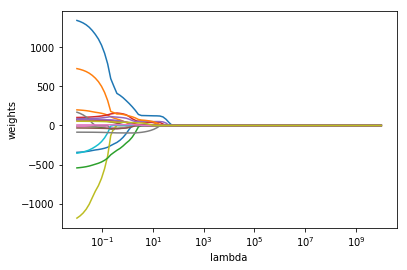

In [84]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in lambdas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(lambdas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning parameter, some of the coefficients are exactly equal to zero. We now perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [85]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

99096.77050496225

This is substantially lower than the test set MSE of the null model and of least squares, and only a little worse than the test MSE of ridge regression with alpha chosen by cross-validation.
However, the lasso has a substantial advantage over ridge regression in that the resulting coefficient estimates are sparse. Here we see that 13 of the 19 coefficient estimates are exactly zero:

In [86]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits             1.254726
HmRun            0.000000
Runs             1.640634
RBI              2.070501
Walks            0.000000
Years            0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns            0.324839
CRBI             0.165646
CWalks           0.000000
PutOuts          0.000000
Assists          0.000000
Errors          -0.000000
League_N         0.000000
Division_W    -148.005298
NewLeague_N     40.342960
dtype: float64